## Environment Setup and Data Loading

**date:** The date on which the house was sold  
**price:** The sale price of the house.  
**bedrooms:** Number of bedrooms in the house   
**bathrooms:** Number of bathrroms in the house     
**sqft_living:** The square footage of the interior living space    
**sqft_lot:** The square footage of the total land lot      
**floors:** Total number of floors (levels) in the house    
**waterfront:** A binary variable indicating whether the house has a waterfront view    
**view:** An index (typically 0 to 4) rating the quality of the view from the property (e.g., mountains, skyline, water)    
**condition:** A rating (1 to 5) of the overall condition of the house. This relates to the maintenance level (1 = Poor, 5 = Very Good)     
**grade:** A rating (1 to 13) of the construction quality and design.   
**sqft_above:** The square footage of the house that is above ground level (excluding the basement)     
**sqft_basement:** The square footage of the basement area  
**yr_built:** The year the house was originally constructed     
**yr_renovated:** The year the house was renovated. If the house was never renovated, this value is often 0 or NA
**zipcode:** The 5-digit ZIP code where the property is located     
**lat:** The latitude coordinate of the property    
**long:** The longitude coordinate of the property  
**sqft_living15:** The average square footage of interior living space for the closest 15 neighbors     
**sqft_lot15:** The average square footage of the land lots for the closest 15 neighbors  

In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

# Pipeline & Modeling
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder

# Linear Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV

# Random Forest
from sklearn.ensemble import RandomForestRegressor

# XGBoost
import xgboost as xgboost
from xgboost import XGBRegressor


# Evaluation Metrices
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import explained_variance_score, mean_absolute_percentage_error
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


# Load Data
df_before_cleaning = pd.read_csv('data/kc_house_data.csv')
df = df_before_cleaning
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


## Data Cleaning

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [37]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [38]:
df.duplicated().sum()

0

In [39]:
df = df.drop(columns='id', axis=1)

In [40]:
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [41]:
df.isnull().sum()

date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

No Missing Values

In [42]:
df['date'] = pd.to_datetime(df['date'])
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [43]:
df.nunique()

date              372
price            4028
bedrooms           13
bathrooms          30
sqft_living      1038
sqft_lot         9782
floors              6
waterfront          2
view                5
condition           5
grade              12
sqft_above        946
sqft_basement     306
yr_built          116
yr_renovated       70
zipcode            70
lat              5034
long              752
sqft_living15     777
sqft_lot15       8689
dtype: int64

In [44]:
df['price'].describe()

count    2.161300e+04
mean     5.400881e+05
std      3.671272e+05
min      7.500000e+04
25%      3.219500e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

In [45]:
df['bedrooms'].value_counts()

bedrooms
3     9824
4     6882
2     2760
5     1601
6      272
1      199
7       38
0       13
8       13
9        6
10       3
11       1
33       1
Name: count, dtype: int64

In [46]:
df['bathrooms'].value_counts().count()

30

10 outliers with no bathrooms??

In [47]:
df['bathrooms'].value_counts()

bathrooms
2.50    5380
1.00    3852
1.75    3048
2.25    2047
2.00    1930
1.50    1446
2.75    1185
3.00     753
3.50     731
3.25     589
3.75     155
4.00     136
4.50     100
4.25      79
0.75      72
4.75      23
5.00      21
5.25      13
0.00      10
5.50      10
1.25       9
6.00       6
0.50       4
5.75       4
6.75       2
8.00       2
6.25       2
6.50       2
7.50       1
7.75       1
Name: count, dtype: int64

In [48]:
df['floors'].value_counts()

floors
1.0    10680
2.0     8241
1.5     1910
3.0      613
2.5      161
3.5        8
Name: count, dtype: int64

In [49]:
df['waterfront'].value_counts()

waterfront
0    21450
1      163
Name: count, dtype: int64

In [50]:
df['view'].value_counts()

view
0    19489
2      963
3      510
1      332
4      319
Name: count, dtype: int64

In [51]:
df['condition'].value_counts()

condition
3    14031
4     5679
5     1701
2      172
1       30
Name: count, dtype: int64

In [52]:
df['grade'].value_counts()

grade
7     8981
8     6068
9     2615
6     2038
10    1134
11     399
5      242
12      90
4       29
13      13
3        3
1        1
Name: count, dtype: int64

## Exploratory Data Analysis (EDA)

### Target Variable Analysis

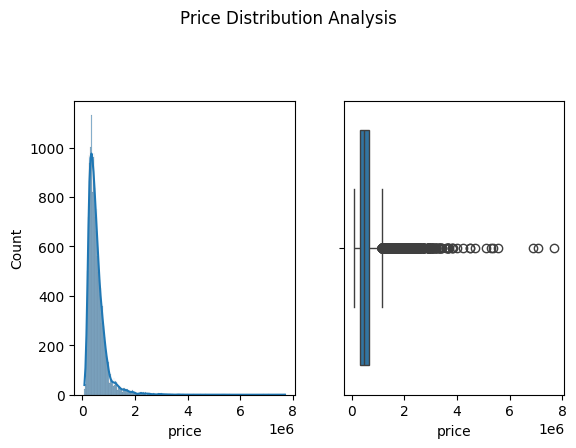

In [53]:
fig, axes = plt.subplots(1,2)
plt.suptitle("Price Distribution Analysis")

sns.histplot(df, x='price', ax= axes[0], kde=True)
sns.boxplot(df, x='price', ax= axes[1])

plt.tight_layout(pad=3)
plt.show()

In [54]:
df['price_log'] = np.log(df['price'])

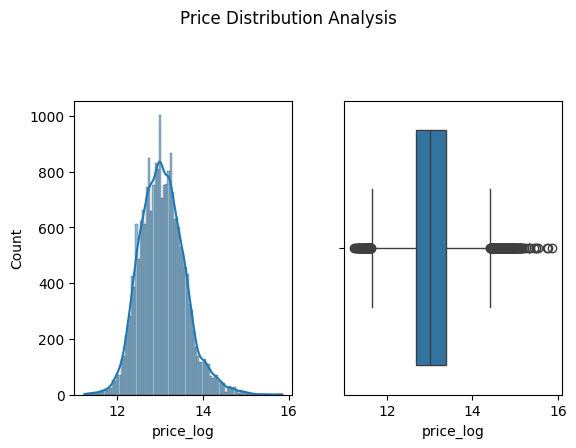

In [55]:
fig, axes = plt.subplots(1,2)
plt.suptitle("Price Distribution Analysis")

sns.histplot(df, x='price_log', ax= axes[0], kde=True)
sns.boxplot(df, x='price_log', ax= axes[1])

plt.tight_layout(pad=3)
plt.show()

Preformed Log Transform since price data is too skewed

In [56]:
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price_log
0,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,3,...,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,12.309982
1,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,3,...,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,13.195614
2,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,3,...,770,0,1933,0,98028,47.7379,-122.233,2720,8062,12.100712
3,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,5,...,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,13.311329
4,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,3,...,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,13.142166


### Univariate Analysis

#### Continous Variables

In [ ]:
continous_features = df.drop(columns=['date','price', 'waterfront', 'view', 'condition', 'grade', 'price_log'])
continous_features.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,3,1.00,1180,5650,1.0,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,3,2.25,2570,7242,2.0,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,2,1.00,770,10000,1.0,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,4,3.00,1960,5000,1.0,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,3,2.00,1680,8080,1.0,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [ ]:
len(continous_features.columns)

14

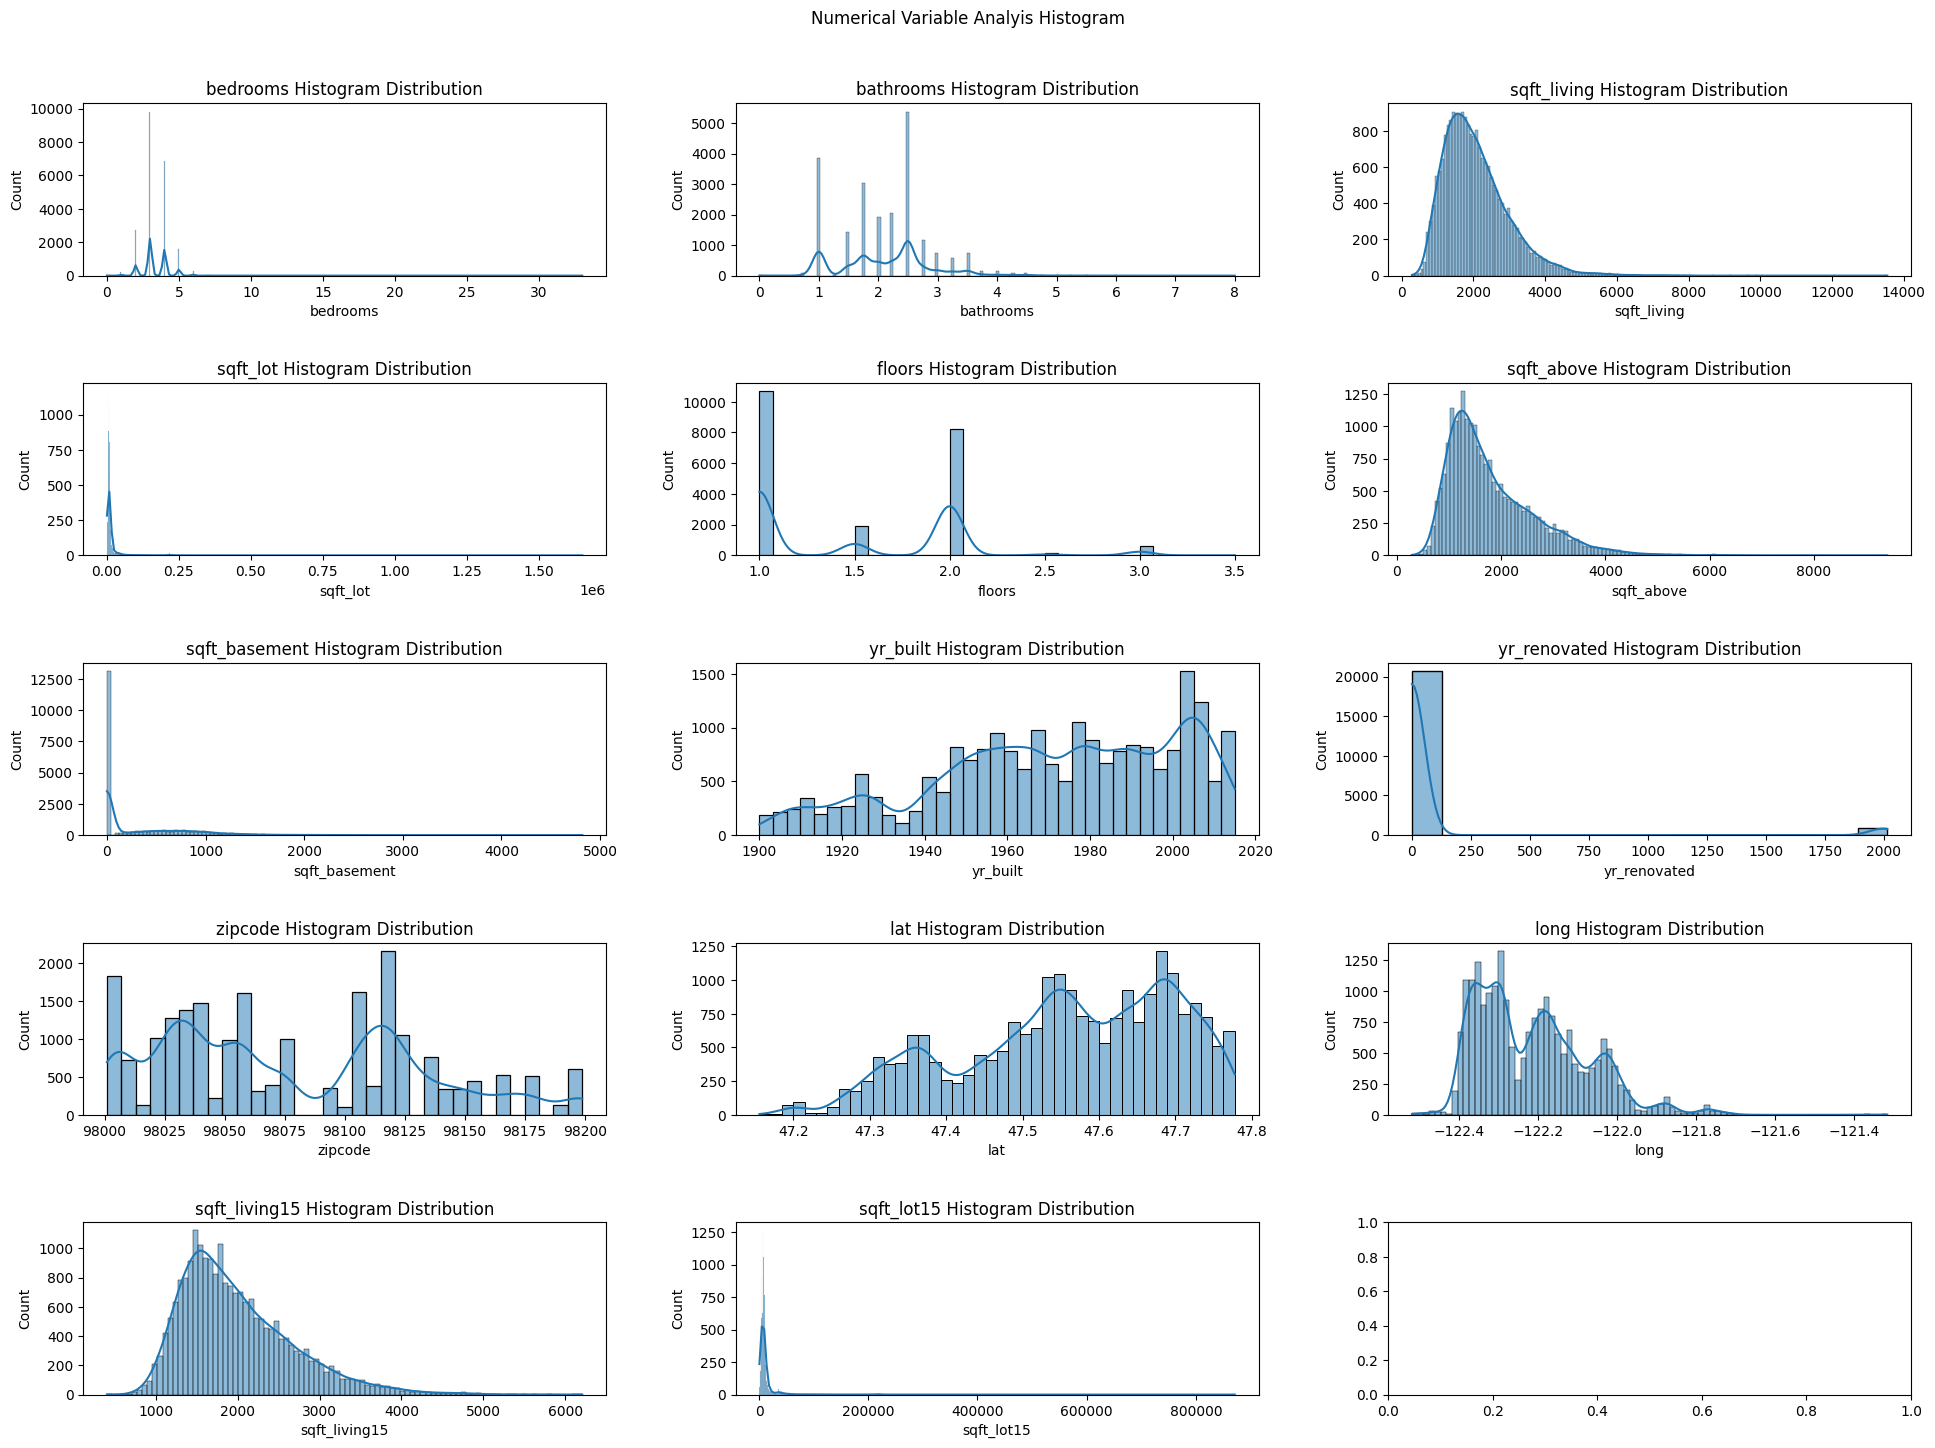

In [ ]:
import math

fig , axes = plt.subplots(math.ceil(len(continous_features.columns)/3), 3, figsize=(20, 15))

plt.suptitle("Numerical Variable Analyis Histogram")

for i, col in enumerate(continous_features.columns):
    sns.histplot(continous_features, x=col, ax= axes[i//3,i%3], kde=True)
    axes[i//3,i%3].set_title(f"{col} Histogram Distribution")

plt.tight_layout(pad=3)
plt.show()

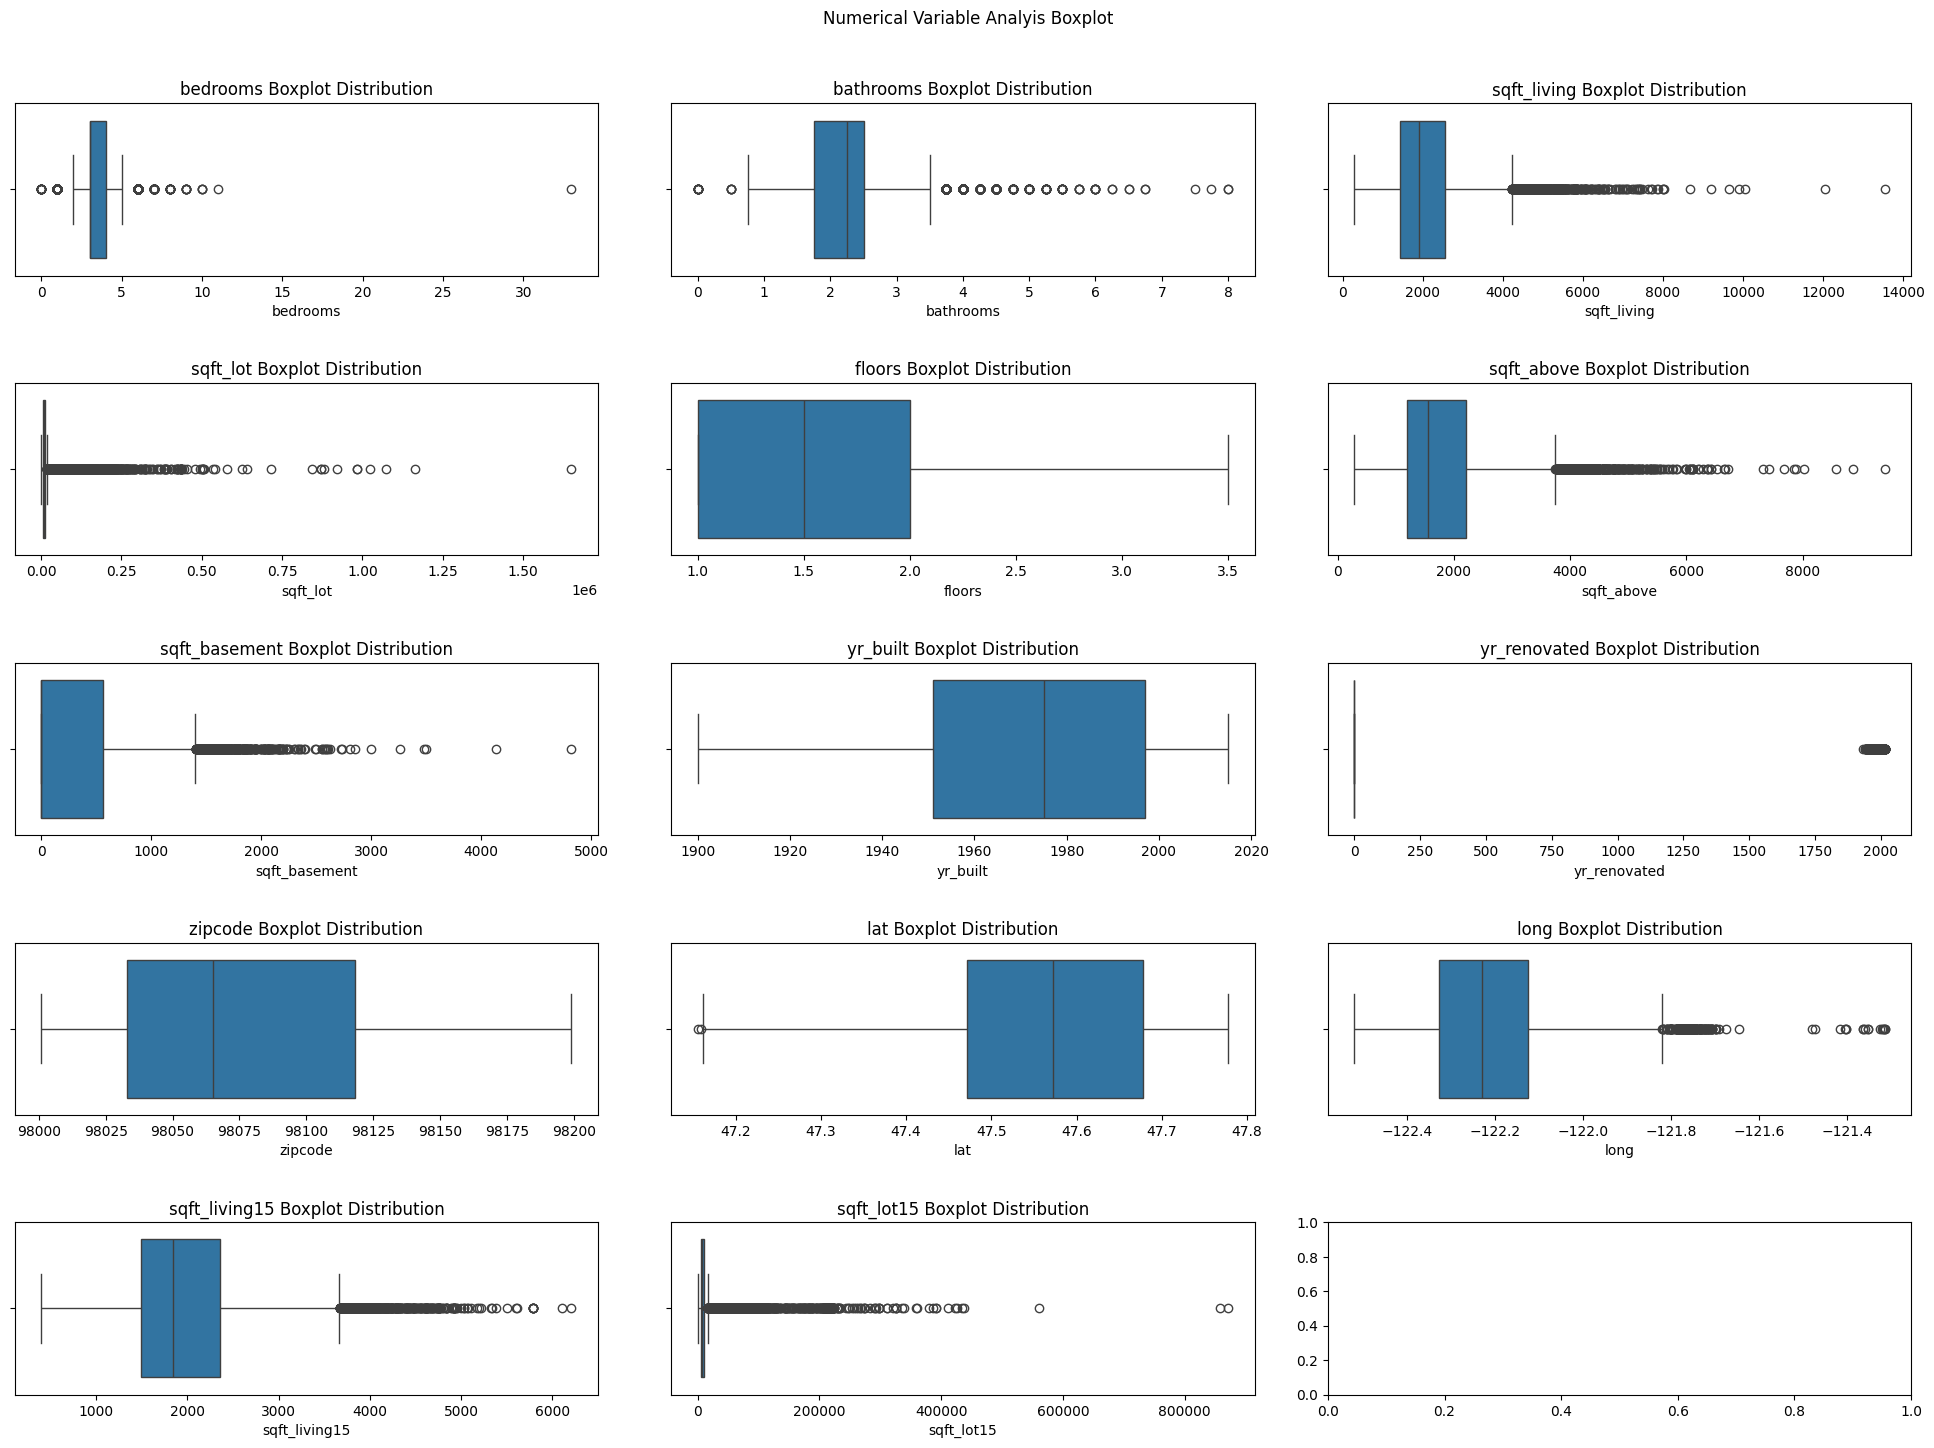

In [ ]:
fig , axes = plt.subplots(math.ceil(len(continous_features.columns)/3), 3, figsize=(20, 15))

plt.suptitle("Numerical Variable Analyis Boxplot")

for i, col in enumerate(continous_features.columns):
    sns.boxplot(continous_features, x=col, ax= axes[i//3,i%3])
    axes[i//3,i%3].set_title(f"{col} Boxplot Distribution")

plt.tight_layout(pad=3)
plt.show()

In [61]:
df['sqft_basement'].value_counts()

sqft_basement
0      13126
600      221
700      218
500      214
800      206
       ...  
518        1
374        1
784        1
906        1
248        1
Name: count, Length: 306, dtype: int64

In [62]:
df['yr_renovated'].value_counts()

yr_renovated
0       20699
2014       91
2013       37
2003       36
2005       35
        ...  
1951        1
1959        1
1948        1
1954        1
1944        1
Name: count, Length: 70, dtype: int64

In [63]:
df.loc[df['bedrooms'] > 10, 'bedrooms'] = 10
df['bedrooms'].value_counts()

bedrooms
3     9824
4     6882
2     2760
5     1601
6      272
1      199
7       38
0       13
8       13
9        6
10       5
Name: count, dtype: int64

Capping bedrooms at 10

In [64]:
df[['sqft_lot', 'sqft_lot15']] = np.log(df[['sqft_lot', 'sqft_lot15']])

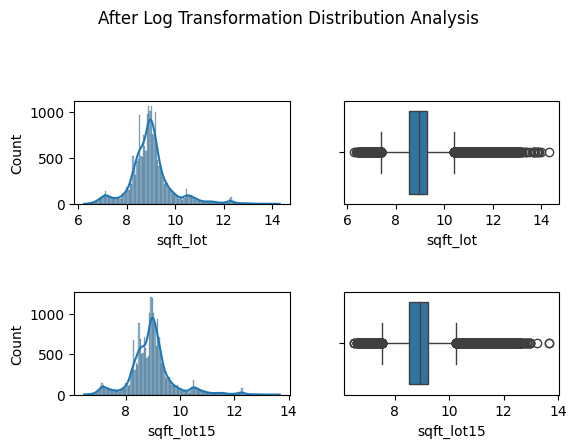

In [65]:
fig, axes = plt.subplots(2,2)
plt.suptitle("After Log Transformation Distribution Analysis")

sns.histplot(df, x='sqft_lot', ax= axes[0,0], kde=True)
sns.boxplot(df, x='sqft_lot', ax= axes[0,1])

sns.histplot(df, x='sqft_lot15', ax= axes[1,0], kde=True)
sns.boxplot(df, x='sqft_lot15', ax= axes[1,1])

plt.tight_layout(pad=3)
plt.show()

log transformed sqft_lot and sqft_lot15

In [66]:
df.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'price_log'],
      dtype='object')

In [67]:
df_square = df.copy()
df_square[['sqft_living', 'sqft_above', 'sqft_basement', 'sqft_living15']] = np.sqrt(df_square[['sqft_living', 'sqft_above', 'sqft_basement', 'sqft_living15']])

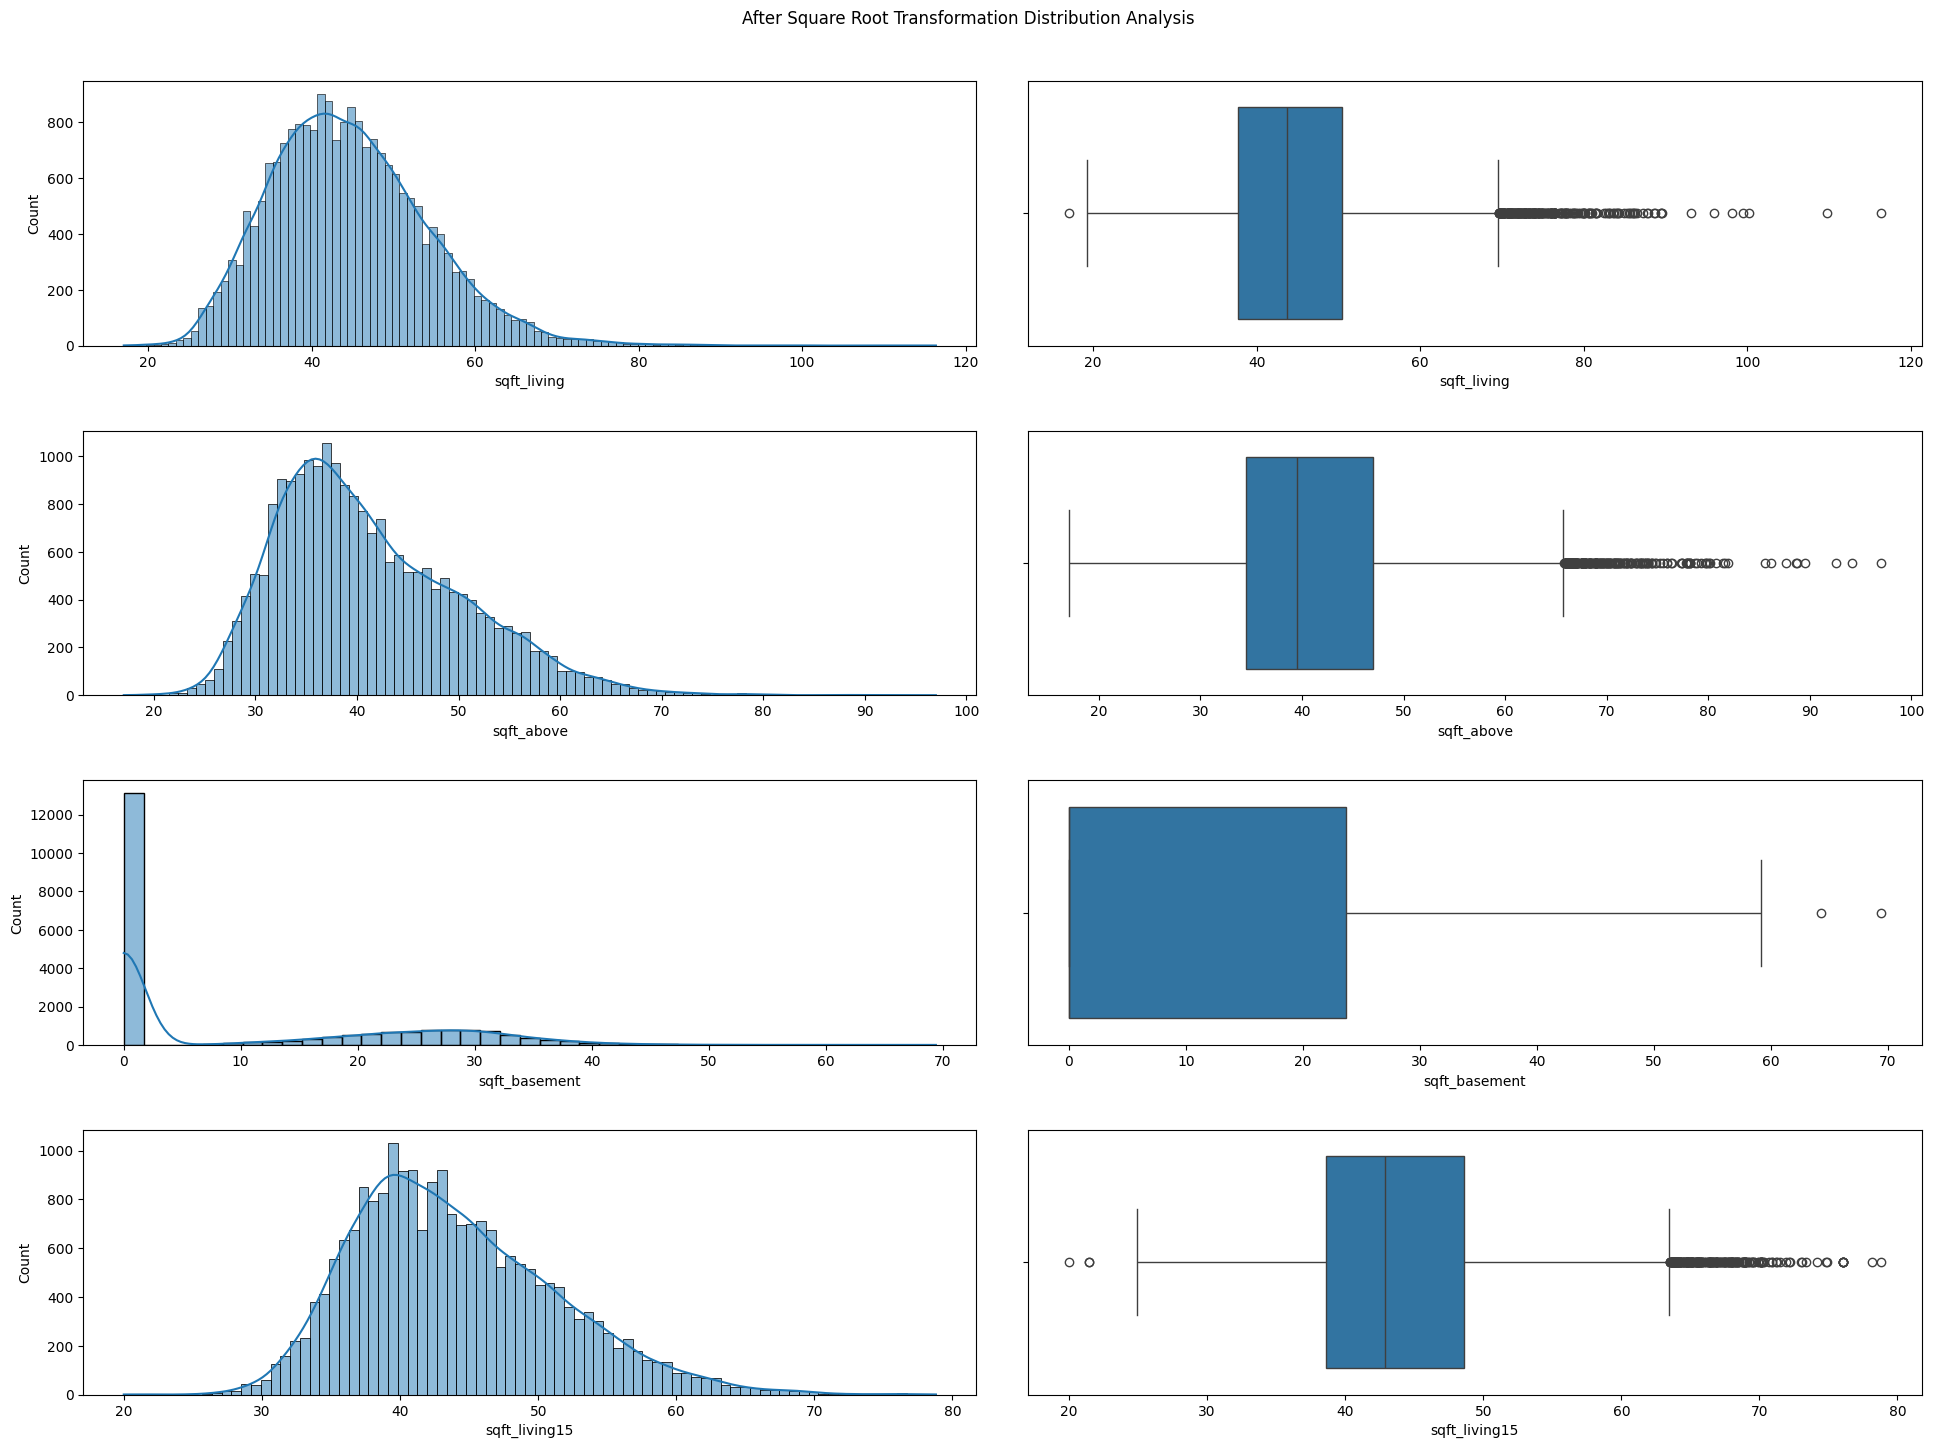

In [68]:
fig, axes = plt.subplots(4,2, figsize=(20,15))

plt.suptitle("After Square Root Transformation Distribution Analysis")

sns.histplot(df_square, x='sqft_living', ax= axes[0,0], kde=True)
sns.boxplot(df_square, x='sqft_living', ax= axes[0,1])

sns.histplot(df_square, x='sqft_above', ax= axes[1,0], kde=True)
sns.boxplot(df_square, x='sqft_above', ax= axes[1,1])

sns.histplot(df_square, x='sqft_basement', ax= axes[2,0], kde=True)
sns.boxplot(df_square, x='sqft_basement', ax= axes[2,1])

sns.histplot(df_square, x='sqft_living15', ax= axes[3,0], kde=True)
sns.boxplot(df_square, x='sqft_living15', ax= axes[3,1])

plt.tight_layout(pad=3)
plt.show()

Considering Square Root or leave it as is

#### Feature Engineering

In [69]:
# option 1 using where

df['basement_flag'] = np.where(df['sqft_basement'] == 0, 0, 1)

# option 2 shortcut 

# df['basement_flag'] = df['sqft_basement'] > 0
# df['basement_flag'] = df['basement_flag'].astype('int')

# option 3 using loc

# df['basement_flag'] = 0
# df.loc[df['sqft_basement'] > 0, 'basement_flag'] = 1

print(df['basement_flag'].value_counts())
print(df['basement_flag'].dtype)

basement_flag
0    13126
1     8487
Name: count, dtype: int64
int32


Adding feature basement_flag

In [70]:
df['renovated_flag'] = np.where(df['yr_renovated'] == 0, 0, 1)

print(df['renovated_flag'].value_counts())
print(df['renovated_flag'].dtype)

renovated_flag
0    20699
1      914
Name: count, dtype: int64
int32


Adding feature renovated_flag

In [71]:
from datetime import datetime

current_year = datetime.now().year

df['house_age'] = current_year - df['yr_built']

print(df['house_age'].value_counts())
print(df['house_age'].dtype)
print(df['house_age'].head())

house_age
12     559
20     454
21     450
22     433
23     422
      ... 
93      30
125     29
124     27
91      24
92      21
Name: count, Length: 116, dtype: int64
int64
0    71
1    75
2    93
3    61
4    39
Name: house_age, dtype: int64


Add feature house_age which is the age since it was built

In [72]:
df['sqft_total'] = df['sqft_above'] + df['sqft_basement']

In [73]:
df_check_living_total = df.copy()
df_check_living_total['calculated_total'] = df_check_living_total['sqft_above'] + df_check_living_total['sqft_basement']
df_check_living_total['difference'] = df_check_living_total['sqft_living'] - df_check_living_total['calculated_total']

# Summary stats
print(df_check_living_total['difference'].describe())

# See where they differ
diff_mask = abs(df_check_living_total['difference']) > 100
print(f"Rows where they differ significantly: {diff_mask.sum()}")
print(df_check_living_total[diff_mask][['sqft_living', 'sqft_above', 'sqft_basement', 'difference']].head(10))

count    21613.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: difference, dtype: float64
Rows where they differ significantly: 0
Empty DataFrame
Columns: [sqft_living, sqft_above, sqft_basement, difference]
Index: []


#### **Breaking Discovery**      
sqft_total is the same as sqft_living, so no need to add sqft_total feature

In [78]:
df = df.drop(columns='sqft_total', axis=1)

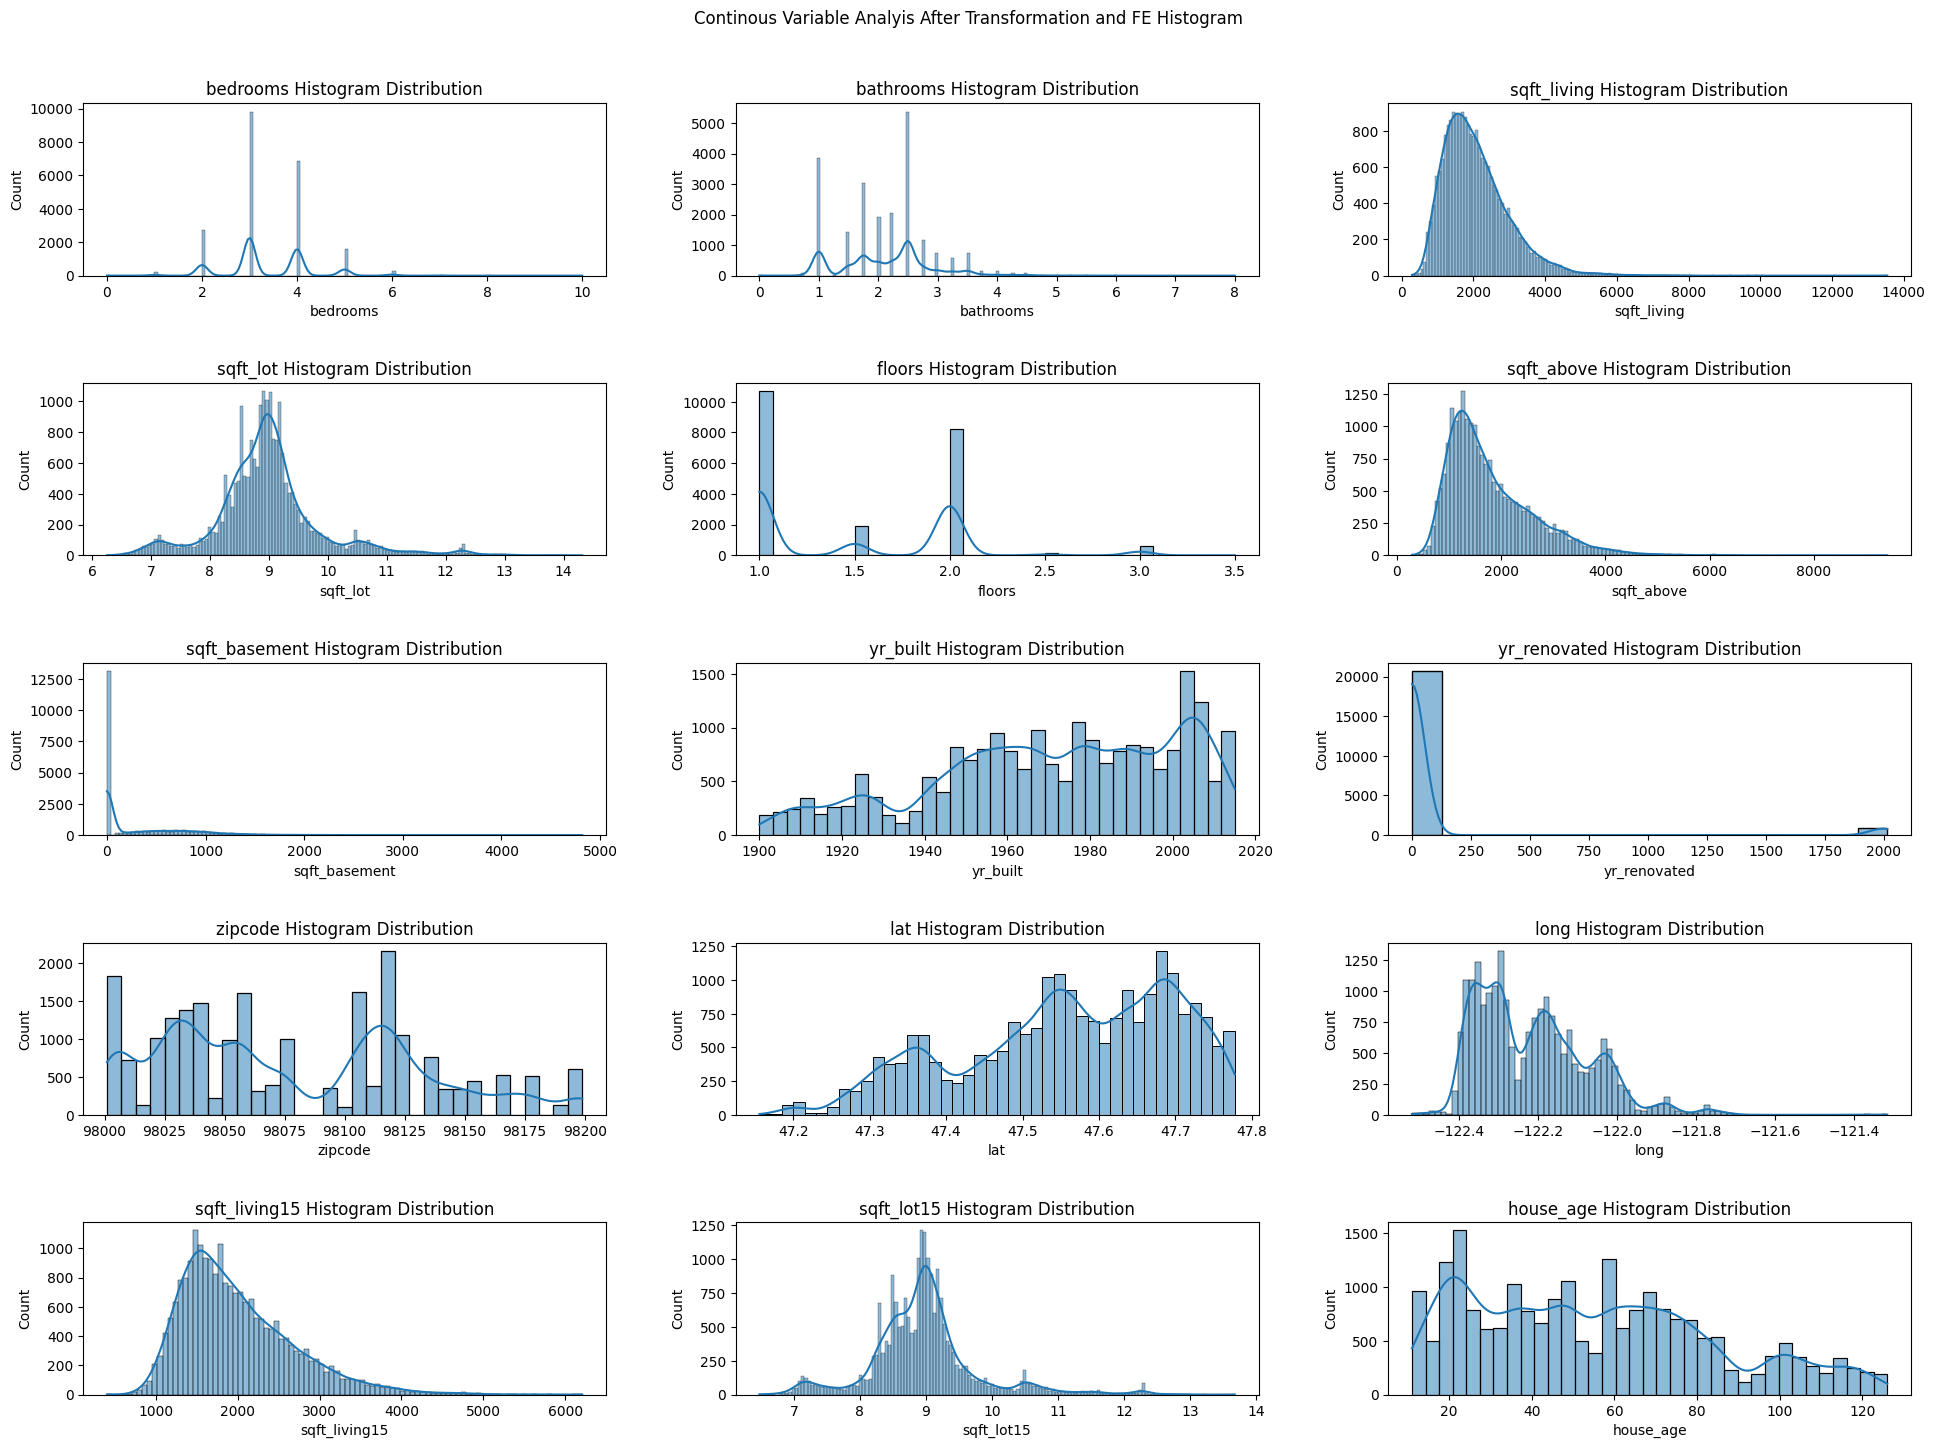

In [79]:
continous_features_after = df.drop(columns=['date','price', 'waterfront', 'view', 'condition', 'grade', 'price_log', 'basement_flag', 'renovated_flag'])

fig , axes = plt.subplots(math.ceil(len(continous_features_after.columns)/3), 3, figsize=(20, 15))

plt.suptitle("Continous Variable Analyis After Transformation and FE Histogram")

for i, col in enumerate(continous_features_after.columns):
    sns.histplot(continous_features_after, x=col, ax= axes[i//3,i%3], kde=True)
    axes[i//3,i%3].set_title(f"{col} Histogram Distribution")

plt.tight_layout(pad=3)
plt.show()

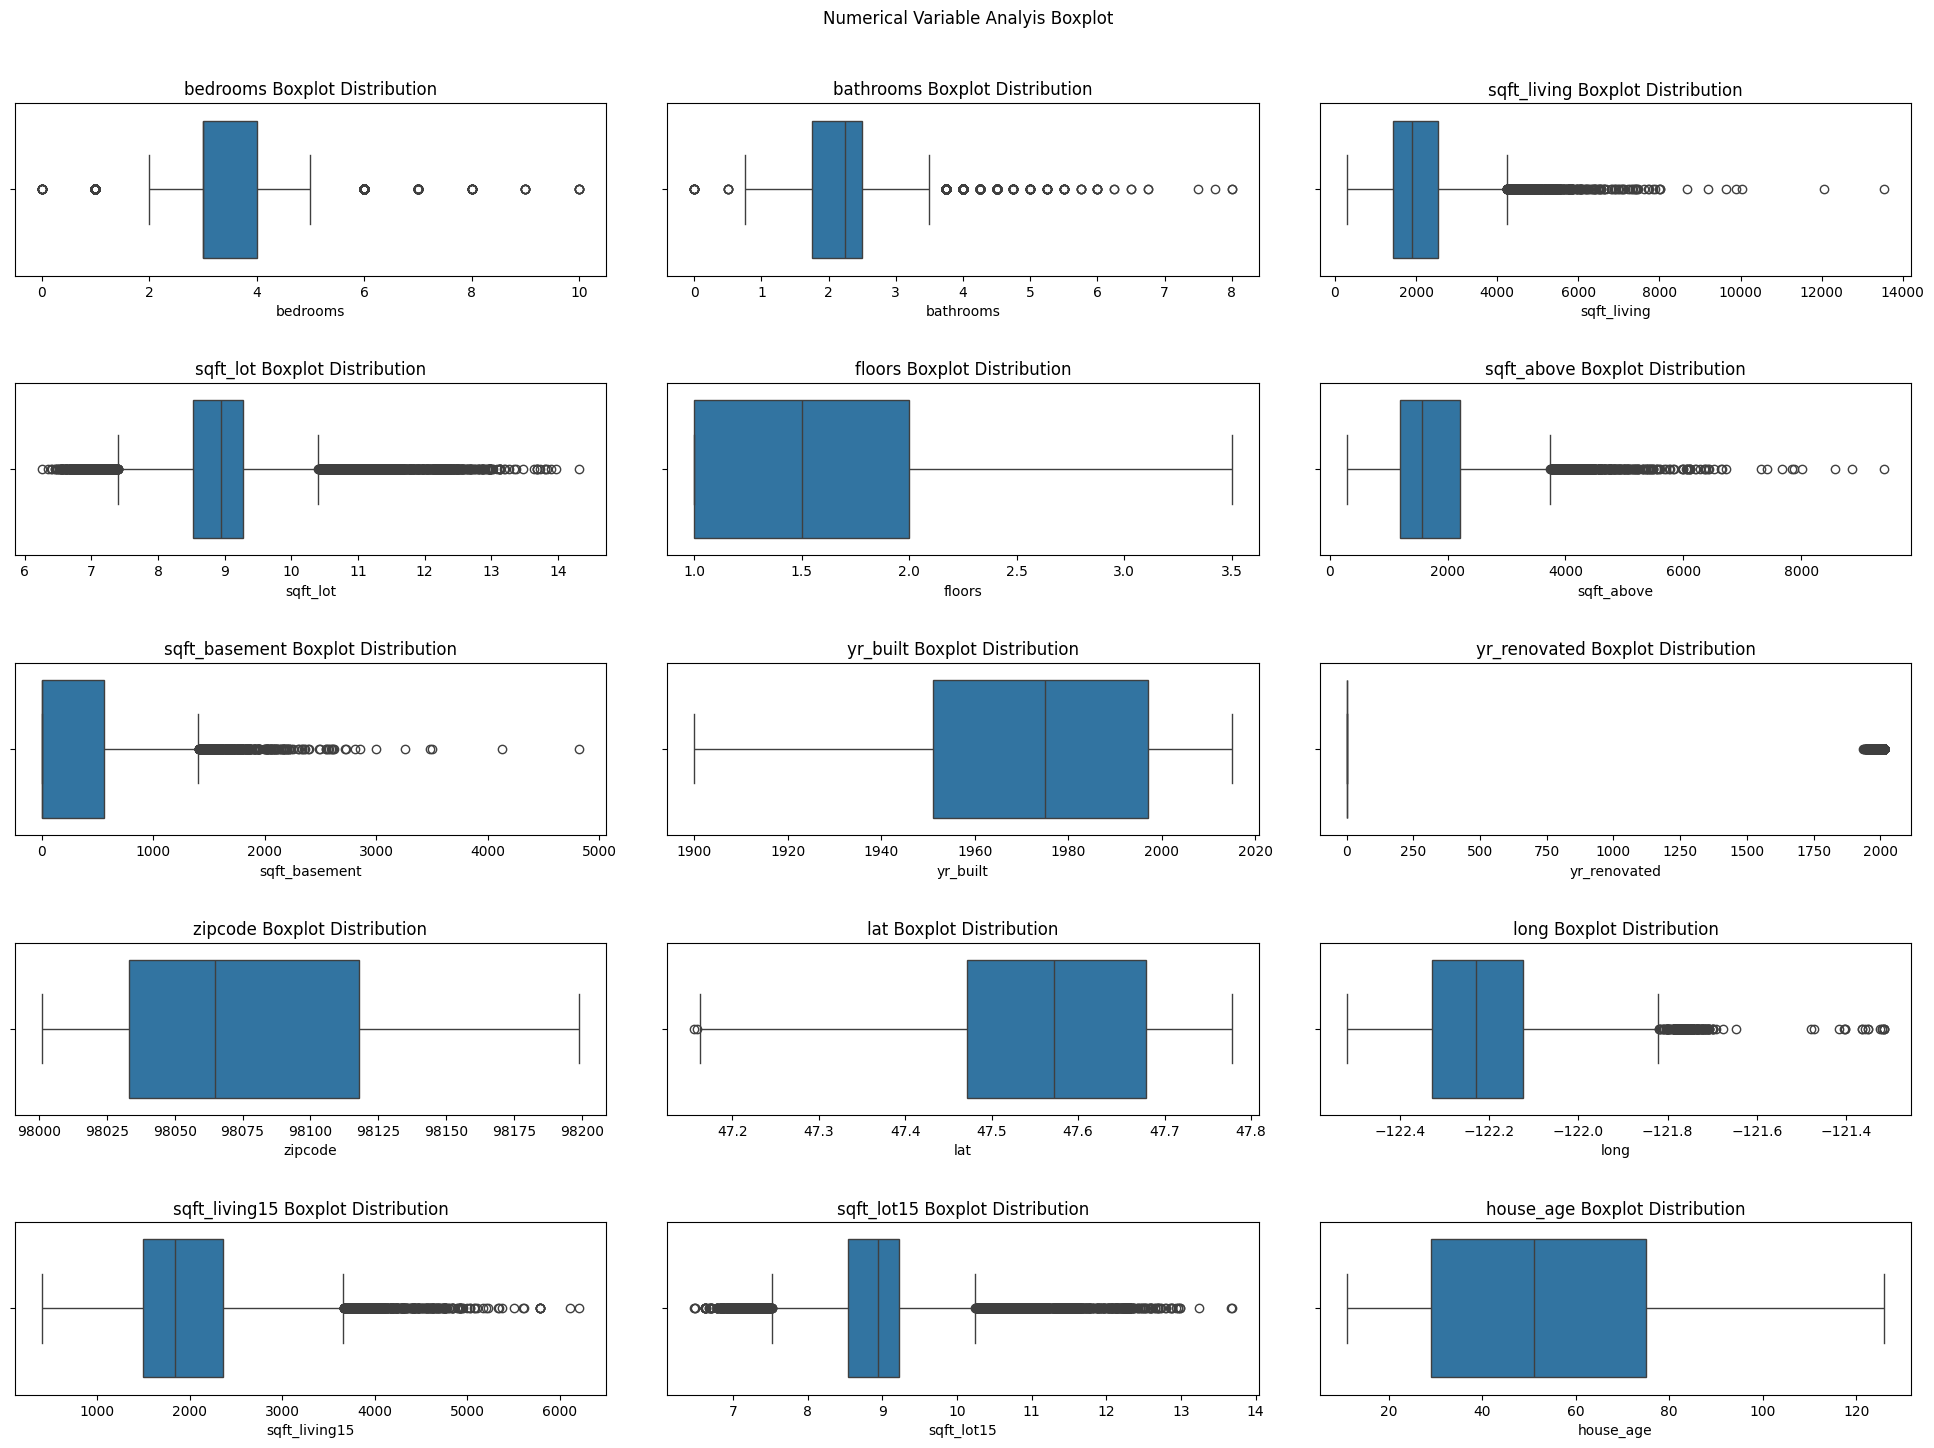

In [80]:
fig , axes = plt.subplots(math.ceil(len(continous_features_after.columns)/3), 3, figsize=(20, 15))

plt.suptitle("Numerical Variable Analyis Boxplot")

for i, col in enumerate(continous_features_after.columns):
    sns.boxplot(continous_features_after, x=col, ax= axes[i//3,i%3])
    axes[i//3,i%3].set_title(f"{col} Boxplot Distribution")

plt.tight_layout(pad=3)
plt.show()

We can cap sqft_total at 10,000
We can remove yr_built and yr_renovated

In [ ]:
column = df['sqft_living15']

print(column.describe())
print(f"Skewness: {column.skew():.2f}")
print(f"Kurtosis: {column.kurtosis():.2f}")

Q1 = column.quantile(0.25)
Q3 = column.quantile(0.75)
IQR = Q3 - Q1
outliers = df[(column < Q1 - 1.5*IQR) | (column > Q3 + 1.5*IQR)]
print(f"Number of outliers: {len(outliers)}")
print(f"Percentage outliers: {len(outliers)/len(df)*100:.2f}%")

print(f"Original Skew: {column.skew():.2f}")
print(f"Sqrt Skew:     {np.sqrt(column).skew():.2f}")
print(f"Log Skew:      {np.log1p(column).skew():.2f}")

count    21613.000000
mean      1986.552492
std        685.391304
min        399.000000
25%       1490.000000
50%       1840.000000
75%       2360.000000
max       6210.000000
Name: sqft_living15, dtype: float64
Skewness: 1.11
Kurtosis: 1.60
Number of outliers: 544
Percentage outliers: 2.52%
Original Skew: 1.11
Sqrt Skew:     0.64
Log Skew:      0.21


After Thorough investigation of data skewness, 'sqft_living', 'sqft_above','sqft_basement','sqft_living15' will be log transformed.     
As for sqft_basement --> By using the flag + Log, the model understands the difference between "no basement" and "size of basement."

In [105]:
df[['sqft_living', 'sqft_above','sqft_basement','sqft_living15']] = np.log(df[['sqft_living', 'sqft_above','sqft_basement','sqft_living15']])

c:\Users\omarh\anaconda3\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


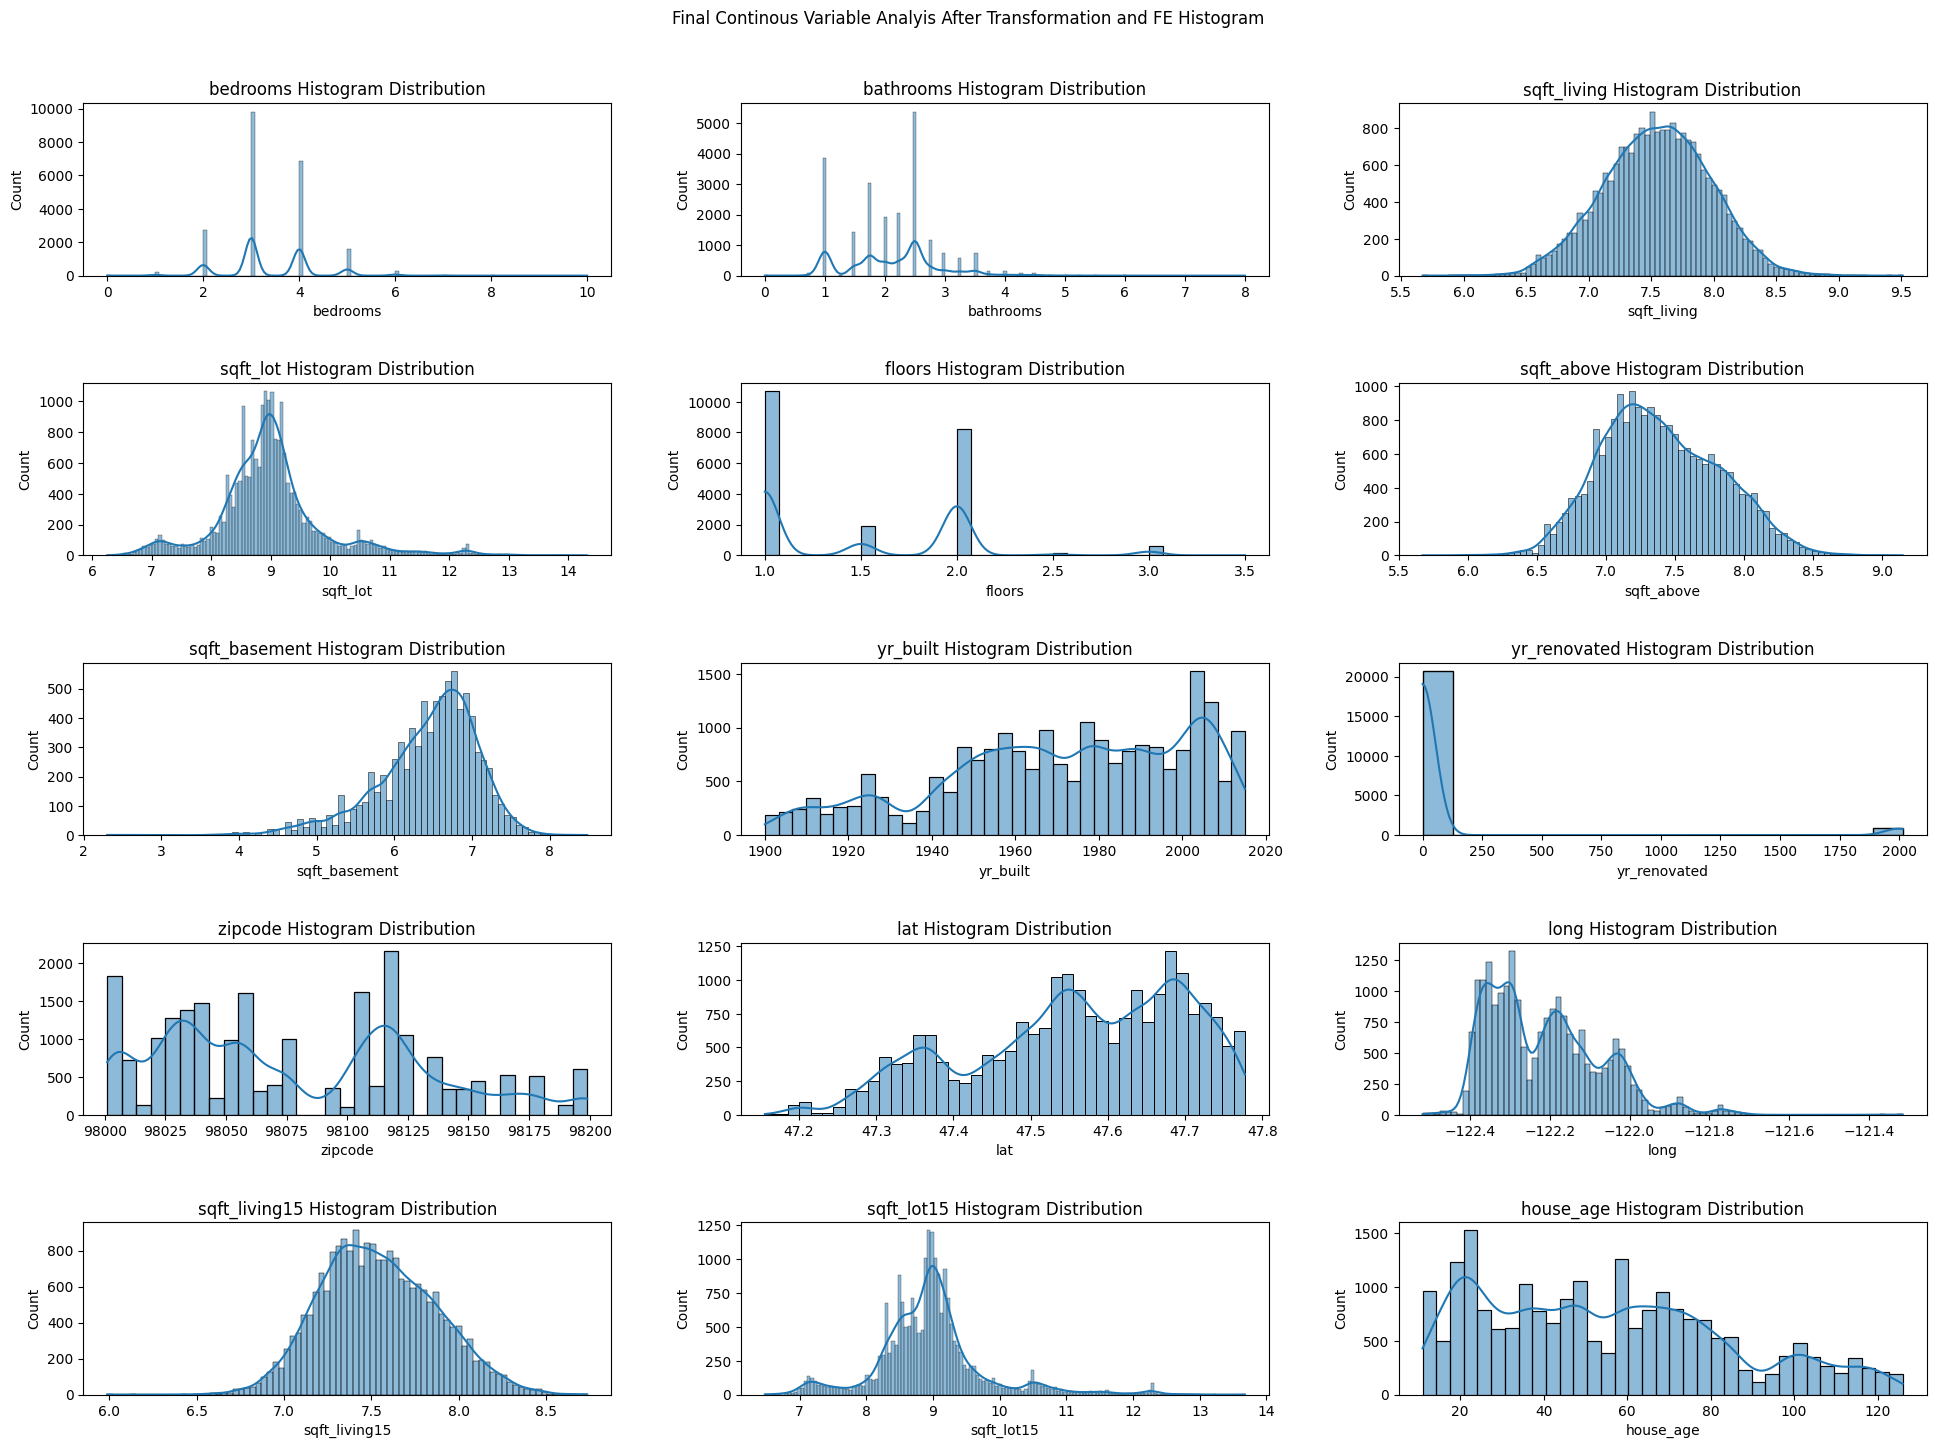

In [106]:
continous_features_after = df.drop(columns=['date','price', 'waterfront', 'view', 'condition', 'grade', 'price_log', 'basement_flag', 'renovated_flag'])

fig , axes = plt.subplots(math.ceil(len(continous_features_after.columns)/3), 3, figsize=(20, 15))

plt.suptitle("Final Continous Variable Analyis After Transformation and FE Histogram")

for i, col in enumerate(continous_features_after.columns):
    sns.histplot(continous_features_after, x=col, ax= axes[i//3,i%3], kde=True)
    axes[i//3,i%3].set_title(f"{col} Histogram Distribution")

plt.tight_layout(pad=3)
plt.show()

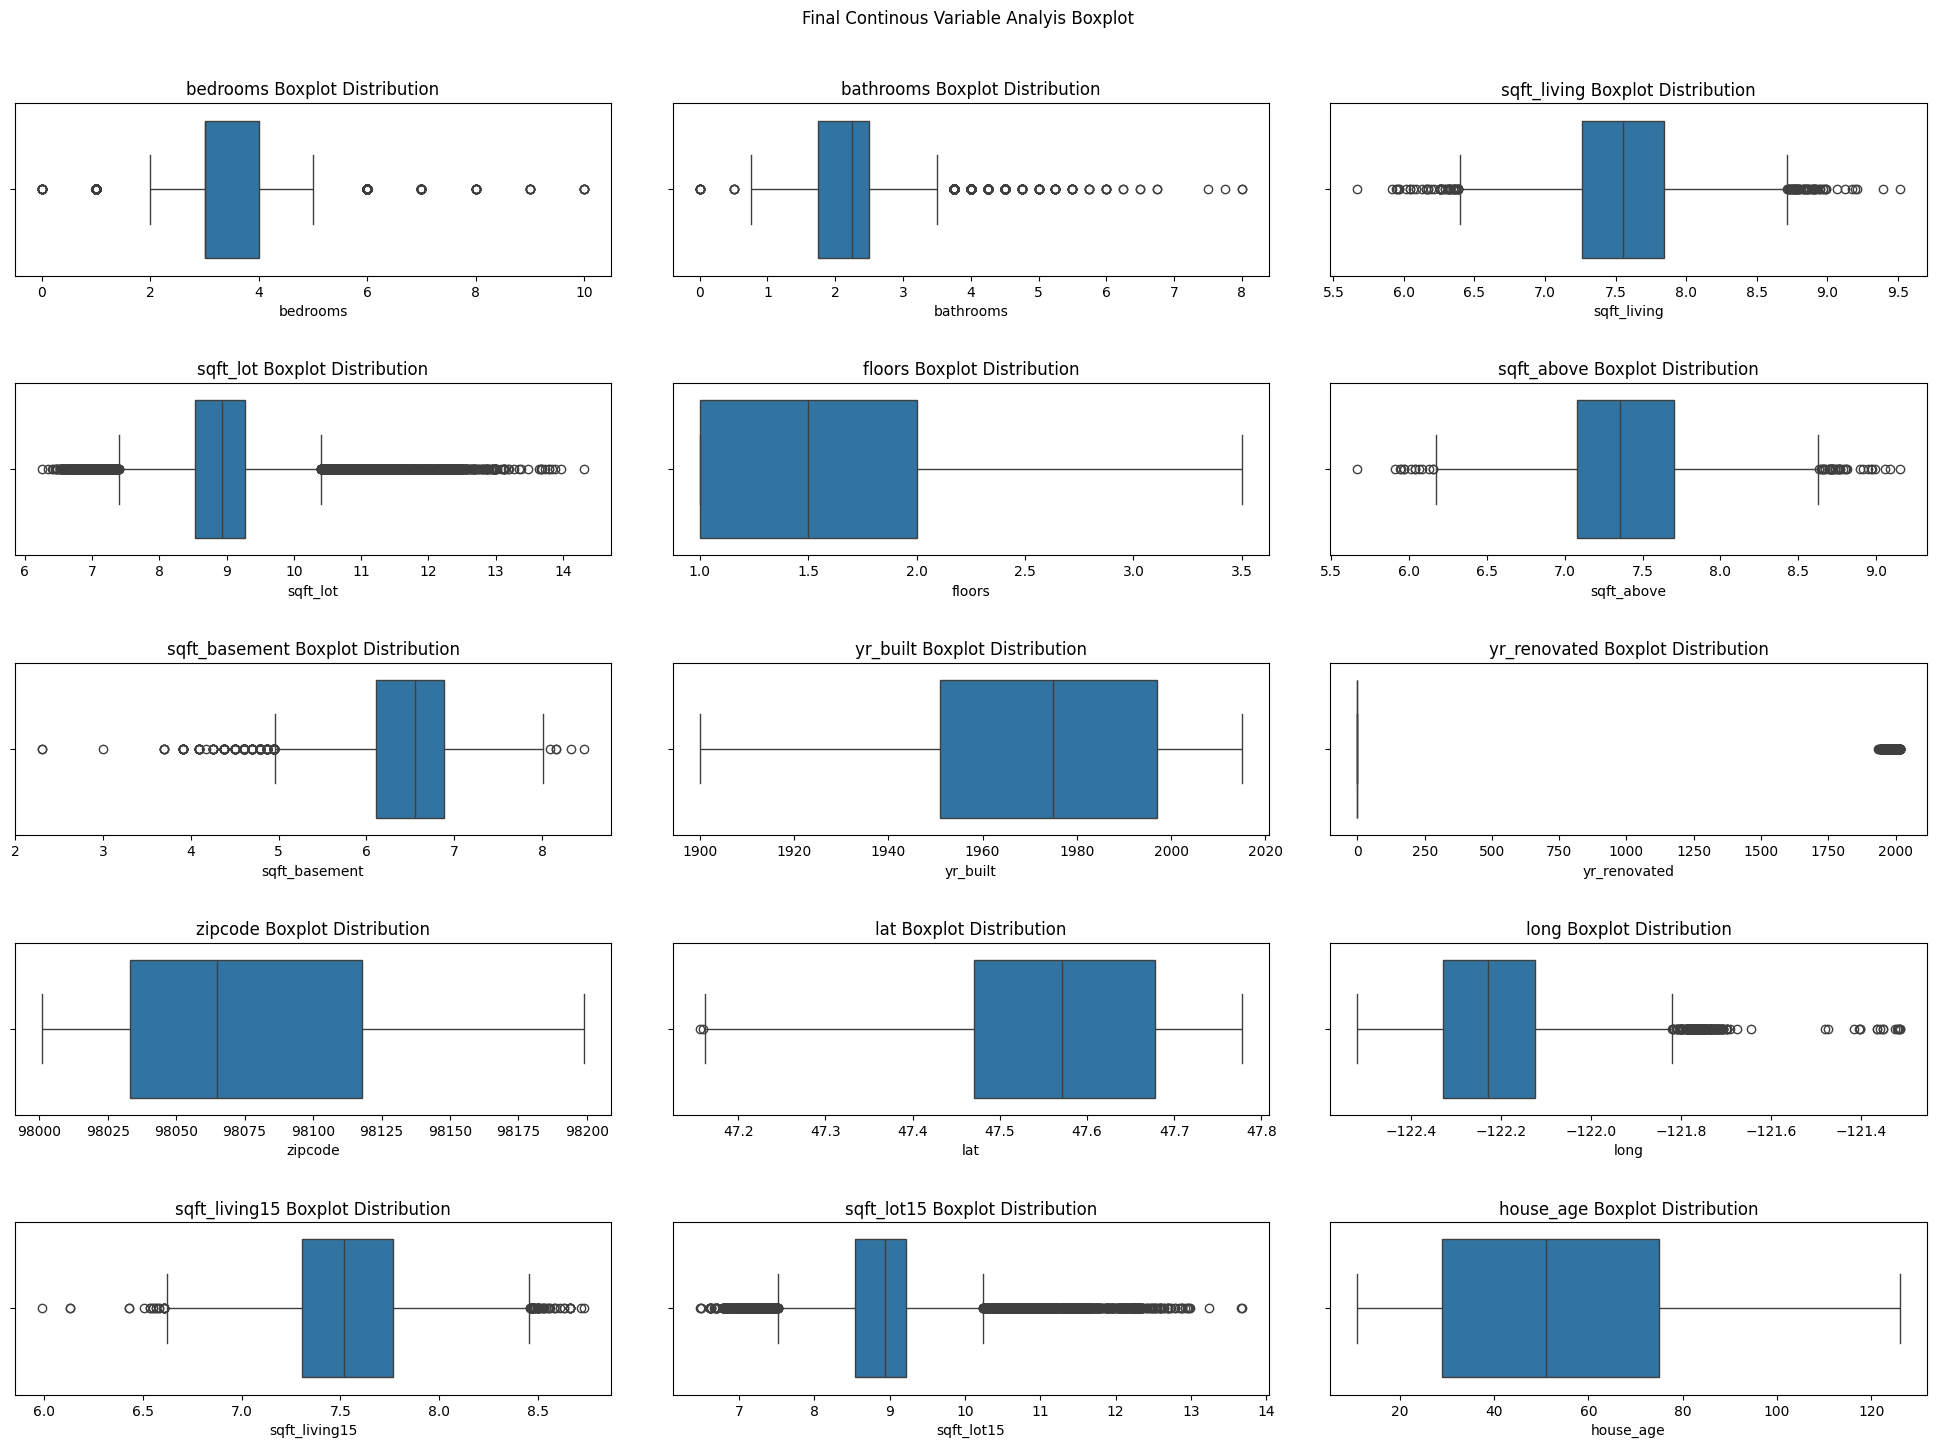

In [107]:
fig , axes = plt.subplots(math.ceil(len(continous_features_after.columns)/3), 3, figsize=(20, 15))

plt.suptitle("Final Continous Variable Analyis Boxplot")

for i, col in enumerate(continous_features_after.columns):
    sns.boxplot(continous_features_after, x=col, ax= axes[i//3,i%3])
    axes[i//3,i%3].set_title(f"{col} Boxplot Distribution")

plt.tight_layout(pad=3)
plt.show()

#### Discrete / Ordinal / Categorical Analysis

In [108]:
discrete_features = df[['waterfront', 'view', 'condition', 'grade','basement_flag', 'renovated_flag']]

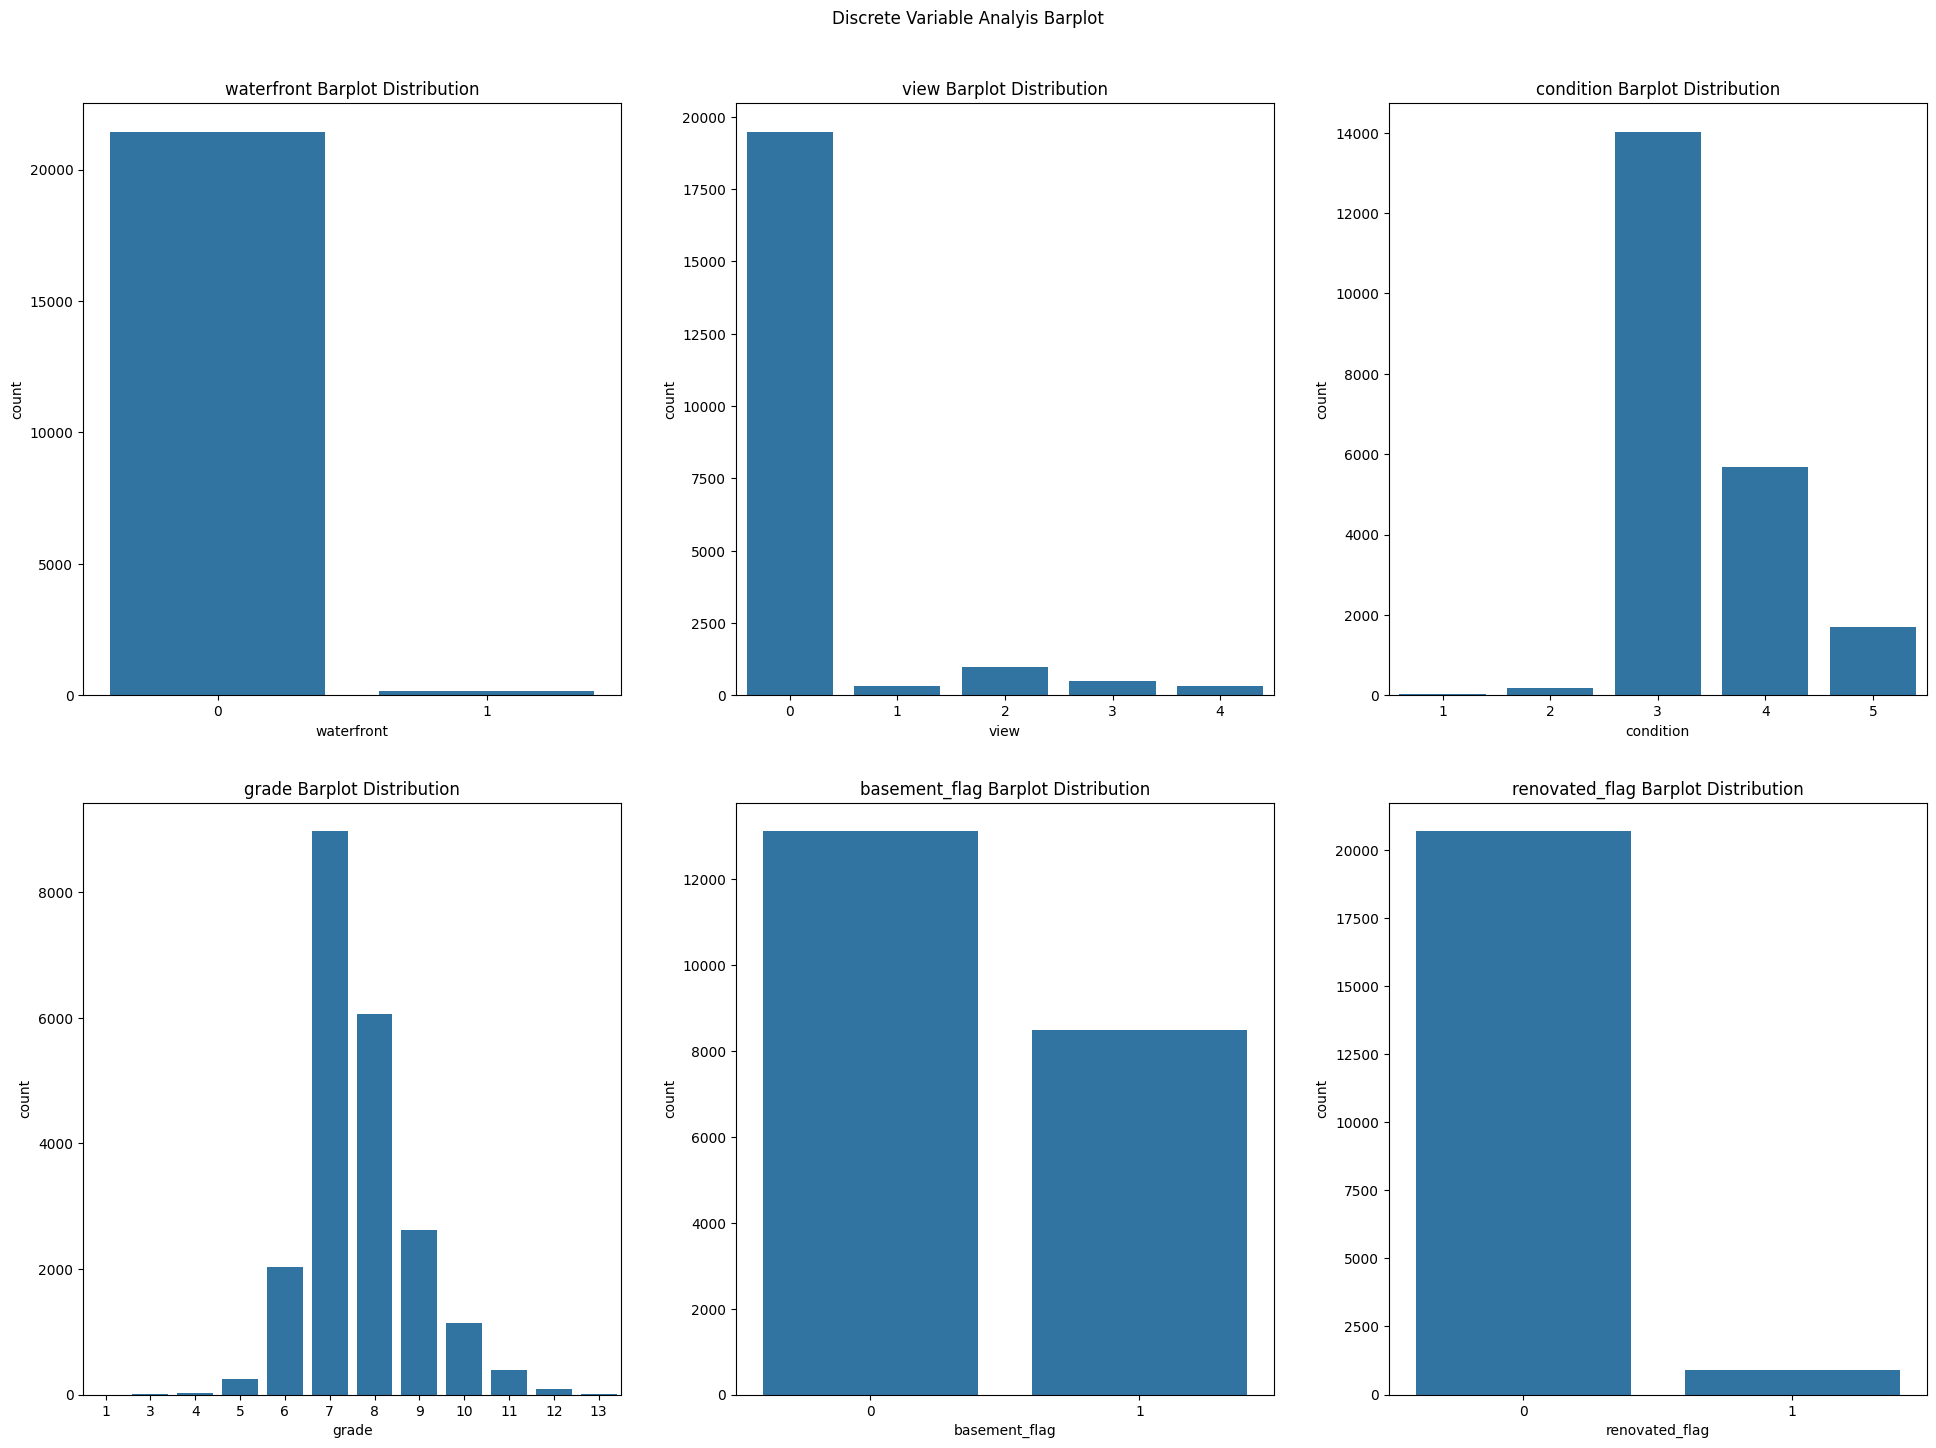

In [ ]:
fig , axes = plt.subplots(math.ceil(len(discrete_features.columns)/3), 3, figsize=(20, 15))

plt.suptitle("Discrete Variable Analyis Countplot")

for i, col in enumerate(discrete_features.columns):
    sns.countplot(discrete_features, x=col, ax= axes[i//3,i%3])
    axes[i//3,i%3].set_title(f"{col} Barplot Distribution")

plt.tight_layout(pad=3)
plt.show()

#### Date Sold analysis

C:\Users\omarh\AppData\Local\Temp\ipykernel_31492\152144116.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  monthly_avg['date'] = pd.to_datetime(monthly_avg['month'].astype(str) + '/' + monthly_avg['year'].astype(str))


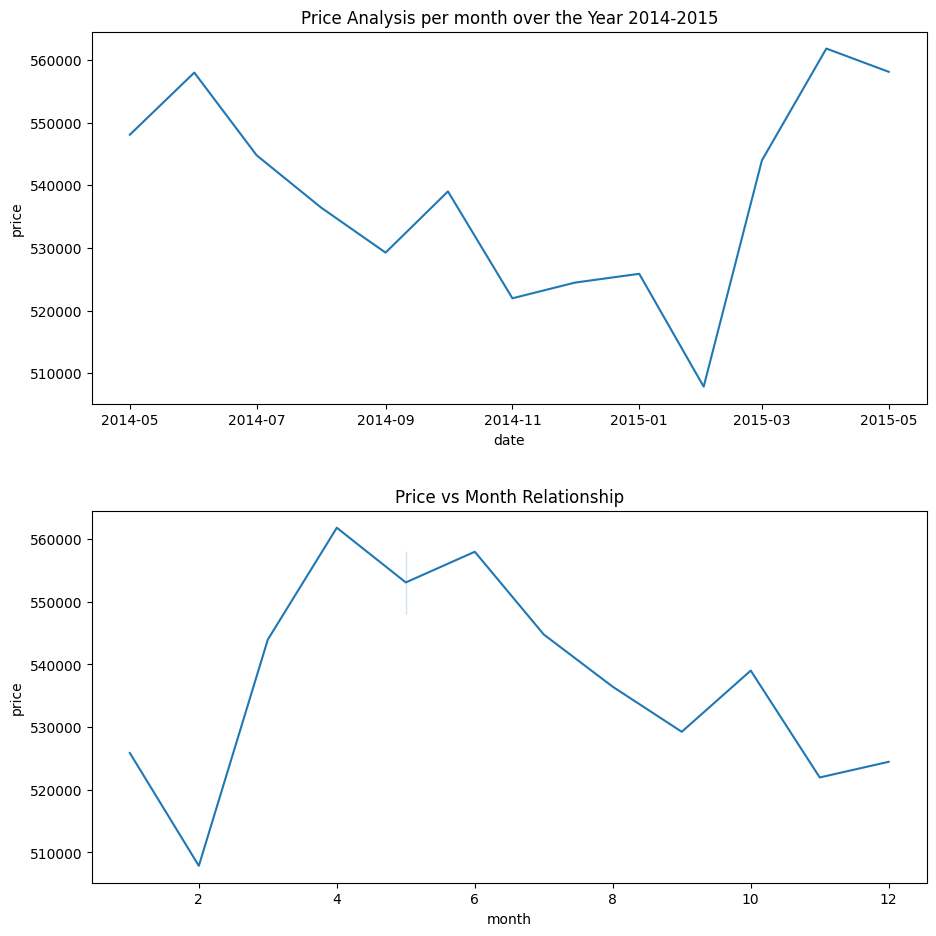

In [137]:
df_month = df.copy()

df_month['month'] = df['date'].dt.month
df_month['year'] = df['date'].dt.year

monthly_avg = df_month.groupby(['year','month'])['price'].mean().reset_index()

monthly_avg['date'] = pd.to_datetime(monthly_avg['month'].astype(str) + '/' + monthly_avg['year'].astype(str))
monthly_avg

fig, axes = plt.subplots(2, 1, figsize=(10,10))

sns.lineplot(monthly_avg, x='date', y='price', ax=axes[0])
axes[0].set_title('Price Analysis per month over the Year 2014-2015')

sns.lineplot(monthly_avg, x='month', y='price', ax=axes[1])
axes[1].set_title('Price vs Month Relationship')

plt.tight_layout(pad=3)
plt.show()

This means month maybe an important feature since as seen here prices are really high in spring compared to winter.

In [138]:
df['month'] = df['date'].dt.month
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,zipcode,lat,long,sqft_living15,sqft_lot15,price_log,basement_flag,renovated_flag,house_age,month
0,2014-10-13,221900.0,3,1.00,7.073270,8.639411,1.0,0,0,3,...,98178,47.5112,-122.257,7.200425,8.639411,12.309982,0,0,71,10
1,2014-12-09,538000.0,3,2.25,7.851661,8.887653,2.0,0,0,3,...,98125,47.7210,-122.319,7.432484,8.941022,13.195614,1,1,75,12
2,2015-02-25,180000.0,2,1.00,6.646391,9.210340,1.0,0,0,3,...,98028,47.7379,-122.233,7.908387,8.994917,12.100712,0,0,93,2
3,2014-12-09,604000.0,4,3.00,7.580700,8.517193,1.0,0,0,5,...,98136,47.5208,-122.393,7.215240,8.517193,13.311329,1,0,61,12
4,2015-02-18,510000.0,3,2.00,7.426549,8.997147,1.0,0,0,3,...,98074,47.6168,-122.045,7.495542,8.923058,13.142166,0,0,39,2


### Bivariate Analysis

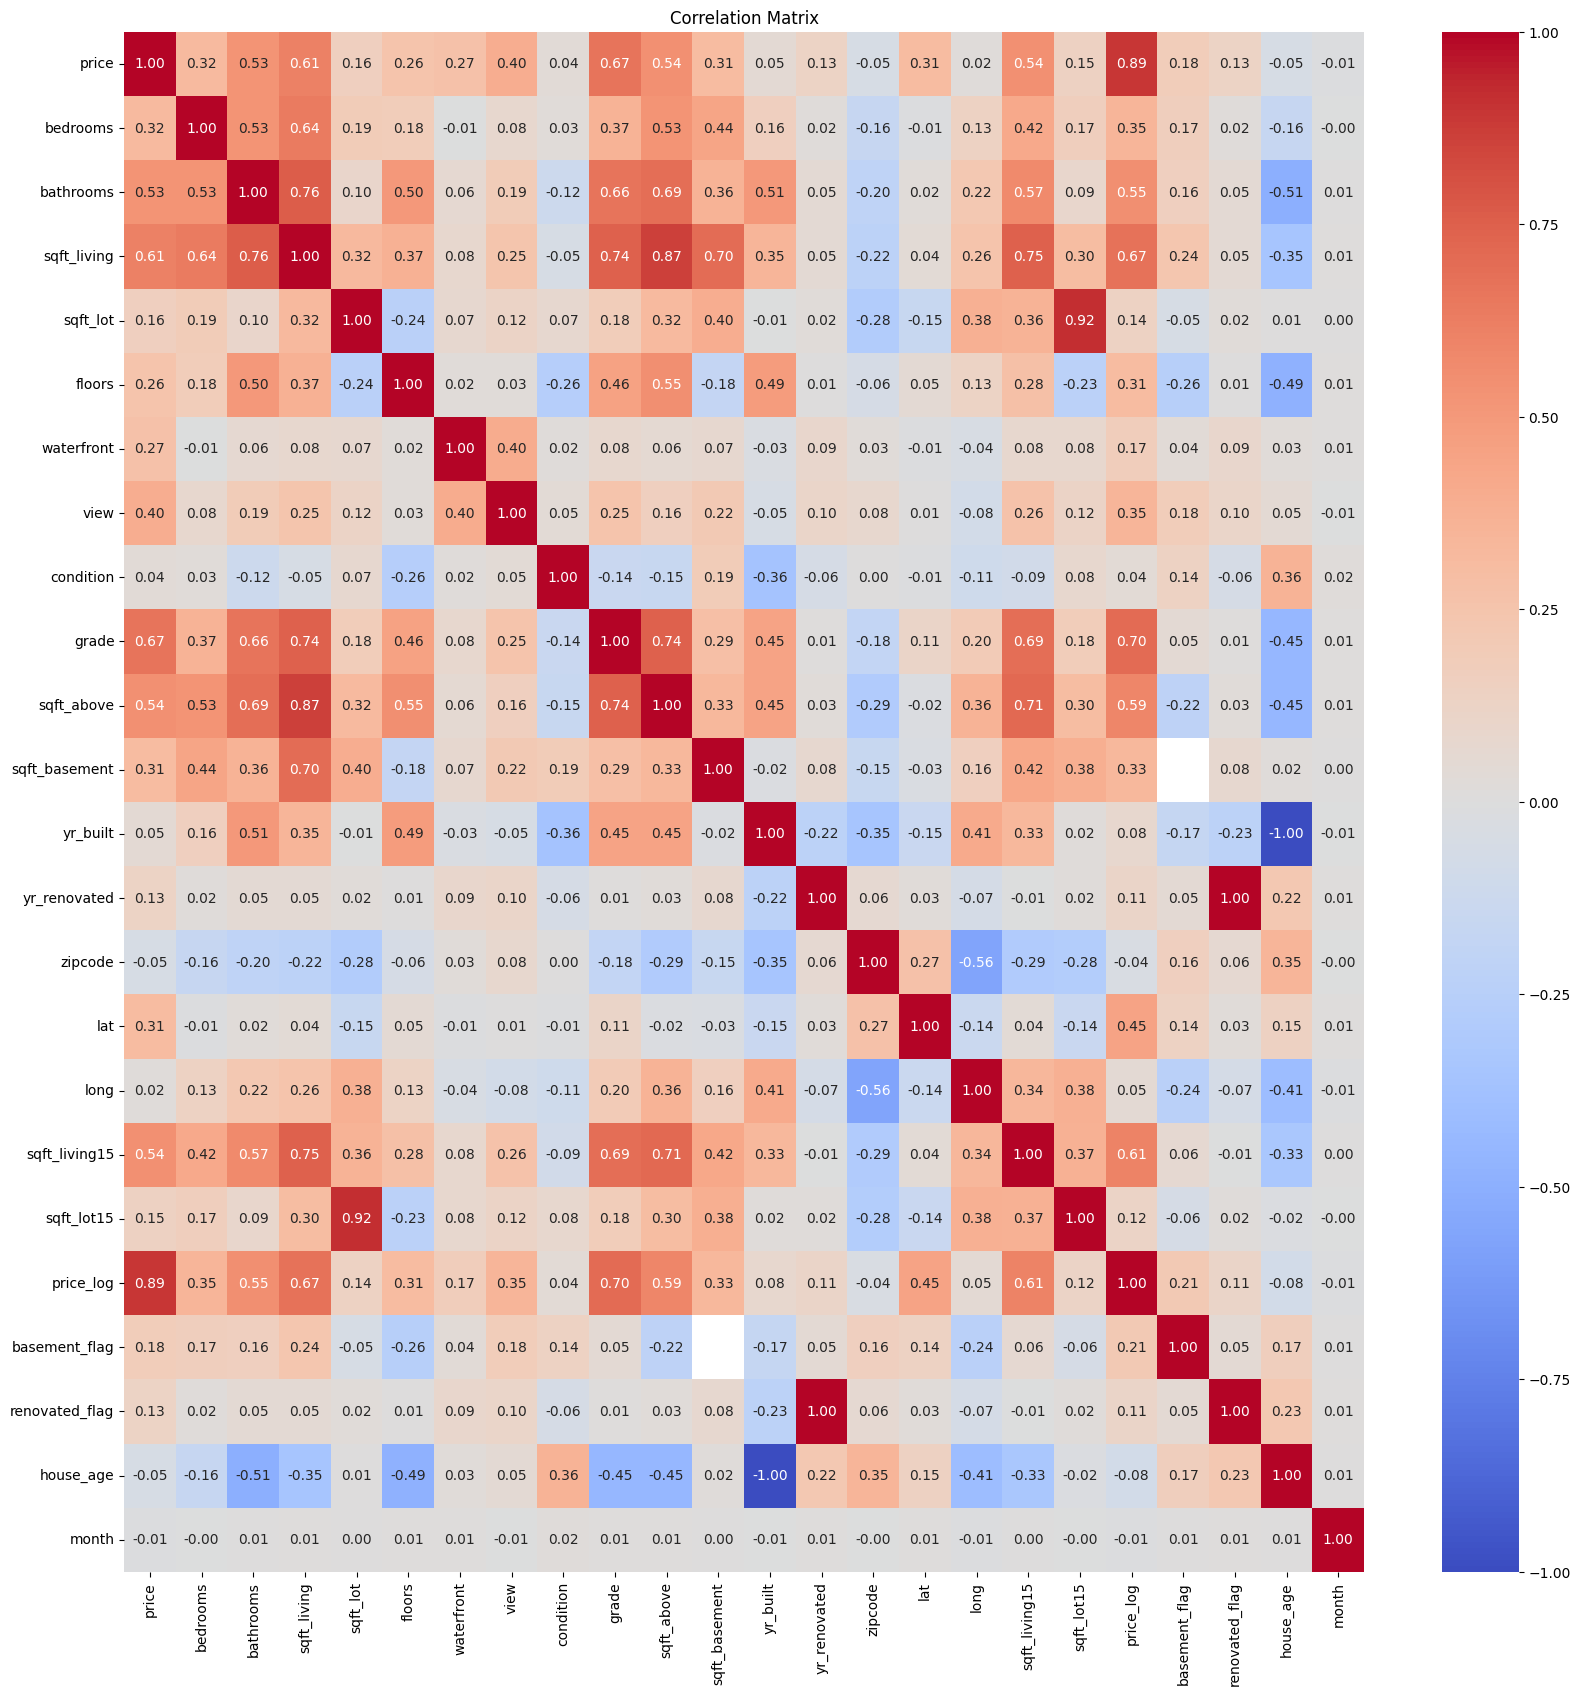

In [141]:
heatmap = df.select_dtypes(include='number')

plt.figure(figsize=(20,20))
sns.heatmap(heatmap.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()